In [ ]:
import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['OMP_NUM_THREADS'] = '4'

# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']= 'platform'
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm
from functools import partial
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import blackjax
from flax.training import train_state
import optax
import jaxopt

import sklearn
import sklearn.datasets

import matplotlib.pyplot as plt
from matplotlib import cm

from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "png")
plt.rcParams["savefig.dpi"] = 75
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = 6, 4
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["font.size"] = 16
plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams["lines.markersize"] = 8
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 1.0
plt.rcParams["legend.facecolor"] = "white"
# plt.rcParams['grid.color'] = "grey"
plt.rcParams["text.usetex"] = True
# plt.rcParams['font.family'] = "normal"
# plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams[
    "text.latex.preamble"
] = "\\usepackage{subdepth} \\usepackage{amsfonts} \\usepackage{type1cm}"


In [ ]:
import torch
import sklearn

seed = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### LOAD DATA
def _one_hot(x, k):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k))

_x_train, _y_train = sklearn.datasets.make_moons(
    n_samples=200, shuffle=True, noise=0.2, random_state=seed
)

h = 0.25
test_lim = 3
x_min, x_max = -5, 5
y_min, y_max = -5, 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
_x_test = np.vstack((xx.reshape(-1), yy.reshape(-1))).T

h = 0.25
test_lim = 7
x_wide_min, x_wide_max = (
    _x_train[:, 0].min() - test_lim,
    _x_train[:, 0].max() + test_lim,
)
y_wide_min, y_wide_max = (
    _x_train[:, 1].min() - test_lim,
    _x_train[:, 1].max() + test_lim,
)
xx_wide, yy_wide = np.meshgrid(
    np.arange(x_wide_min, x_wide_max, h), np.arange(y_wide_min, y_wide_max, h)
)
_x_test_wide = np.vstack((xx_wide.reshape(-1), yy_wide.reshape(-1))).T

_y_test = np.ones(_x_test.shape[0])
_y_test_wide = np.ones(_x_test_wide.shape[0])


x_train = _x_train
y_train = _y_train.reshape(-1, 1)

x_test = _x_test
y_test = _y_test.reshape(-1, 1)

x_test_wide = _x_test_wide
y_test_wide = _y_test_wide.reshape(-1, 1)

In [ ]:
from flax import linen as nn
from typing import Callable

def count_params(model, x):
    params = model.init(jax.random.PRNGKey(0), x)
    n = sum([np.prod(p.shape) for p in jax.tree_util.tree_leaves(params)])
    print(f'Number of parameters: {n/1e3} k')
    
def param_size(params):
    return sum([np.prod(p.shape) for p in jax.tree_util.tree_leaves(params)])

class MLP(nn.Module):
    out_size: int
    H: int = 64
    hidden_layers: int = 1
    act: Callable = nn.relu

    @nn.compact
    def __call__(self, x):
        layers = [nn.Dense(self.H)]
        for _ in range(self.hidden_layers - 1):
            layers += [self.act, nn.Dense(self.H)]
        layers += [self.act, nn.Dense(self.out_size)]
        return nn.Sequential(layers)(x)

def reparam_initializer(initializer, f):
    def init(key, shape, dtype=jnp.float32):
        # sample original parameters and then invert the reparametrization
        return f(initializer(key, shape, dtype))
    return init

class ReparamDense(nn.Module):
    # same as nn.Dense but with reparam weights
    # reparam: Callable = lambda x: x # w = reparam(x)
    # reparam_inv: Callable = lambda x: x # x = reparam_inv(w)
    # bias_init: Callable = reparam_initializer(nn.initializers.normal(stddev=1e-6))
    # kernel_init: Callable = reparam_initializer(nn.initializers.lecun_normal())

    def __init__(self, features, reparam, reparam_inv, init_scale=None):
        super().__init__()
        self.features = features
        self.reparam = reparam
        self.reparam_inv = reparam_inv
        # zero init for bias
        if init_scale is None:
            self.bias_init = reparam_initializer(nn.initializers.normal(stddev=1e-4), f=reparam_inv)
            self.kernel_init = reparam_initializer(nn.initializers.lecun_normal(), f=reparam_inv)
        else:
            self.bias_init = reparam_initializer(nn.initializers.normal(stddev=init_scale), f=reparam_inv)
            self.kernel_init = reparam_initializer(nn.initializers.normal(stddev=init_scale), f=reparam_inv)

    @nn.compact
    def __call__(self, inputs):
        reparam_kernel = self.param('reparam_kernel', self.kernel_init, (inputs.shape[-1], self.features))
        reparam_bias = self.param('reparam_bias', self.bias_init, (1, self.features)) # not using bias_init to avoid dividing by zero
        # invert weights
        kernel = jax.tree_util.tree_map(self.reparam, reparam_kernel)
        bias = jax.tree_util.tree_map(self.reparam, reparam_bias)
        # clamp to avoid numerical issues
        kernel = jnp.clip(kernel, a_min=-1e6, a_max=1e6)
        bias = jnp.clip(bias, a_min=-1e6, a_max=1e6)
        return jnp.dot(inputs, kernel) + bias

class ReparamMLP(nn.Module):
    out_size: int
    H: int = 64
    hidden_layers: int = 1
    reparam: Callable = lambda x: x # w = reparam(x)
    reparam_inv: Callable = lambda x: x # x = reparam_inv(w)
    act: Callable = nn.tanh
    init_scale: float = None

    @nn.compact
    def __call__(self, x):
        layers = [ReparamDense(features=self.H, reparam=self.reparam, reparam_inv=self.reparam_inv, init_scale=self.init_scale)]
        for _ in range(self.hidden_layers - 1):
            layers += [self.act, ReparamDense(features=self.H, reparam=self.reparam, reparam_inv=self.reparam_inv, init_scale=self.init_scale)]
        layers += [self.act, ReparamDense(features=self.out_size, reparam=self.reparam, reparam_inv=self.reparam_inv, init_scale=self.init_scale)]
        out = nn.Sequential(layers)(x)
        return out

In [ ]:
def tree_norm(tree):
    return jnp.sqrt(sum([jnp.sum(x**2) for x in jax.tree_leaves(tree)]))

def random_split_like_tree(rng_key, target=None, treedef=None):
    if treedef is None:
        treedef = jax.tree_structure(target)
    keys = jax.random.split(rng_key, treedef.num_leaves)
    return jax.tree_unflatten(treedef, keys)

@jax.jit
def tree_random_normal_like(rng_key, target):
    keys_tree = random_split_like_tree(rng_key, target)
    return jax.tree_map(
        lambda l, k: jax.random.normal(k, l.shape, l.dtype),
        target,
        keys_tree,
    )

def jacobian_sigular_values(model, p, x):
    jac_rev = jax.jacrev(lambda p, x: model.apply(p, x))
    jac_vmap = jax.vmap(jac_rev, in_axes=(None, 0))
    # j = jac_rev(p, x)
    j = jac_vmap(p, x) # (b, o, p)
    # move the batch axis to last
    j = jax.tree_util.tree_map(lambda x: jnp.einsum('bo...->...bo', x), j)
    # flatten j
    J, _ = jax.flatten_util.ravel_pytree(j)
    P = param_size(p)
    J = J.reshape(P, -1).T # (B*O, P)
    # sigular values of J
    _, S, _ = jnp.linalg.svd(J, full_matrices=False)
    return S

def get_K_matrix(model, p, x):
    jac_rev = jax.jacrev(lambda p, x: model.apply(p, x))
    jac_vmap = jax.vmap(jac_rev, in_axes=(None, 0))
    # j = jac_rev(p, x)
    j = jac_vmap(p, x)
    # move the batch axis to last
    j = jax.tree_util.tree_map(lambda x: jnp.einsum('b...->...b', x), j)
    # flatten j
    J, _ = jax.flatten_util.ravel_pytree(j)
    J = J.reshape(-1, x.shape[0]).T # (N, P)
    N = x.shape[0]
    K = J.T @ J / N # (P, P)
    return K


@partial(jax.jit, static_argnums=(0,3,4,5))
def log_det_g_svd(model, p, x, jitter=1e-6, return_eig=False, shift_by_jitter=True):
    P = param_size(p)
    zeros = jnp.zeros(P)
    s = jacobian_sigular_values(model, p, x) / (x.shape[0] ** 0.5)
    # P eigenvalues, correctly handling the case where P > N
    s = zeros.at[:s.shape[0]].set(s)
    logdet_svd = jnp.sum(jnp.log(s ** 2 + jitter))
    if shift_by_jitter:
        logdet_svd = logdet_svd - P * jnp.log(jitter)
    if return_eig:
        return logdet_svd, s ** 2
    return logdet_svd

@partial(jax.jit, static_argnums=(0,3,4))
def log_det_g_svd_first_order(model, p, x, jitter=1e-6, return_eig=False):
    s = jacobian_sigular_values(model, p, x) / (x.shape[0] ** 0.5)
    logdet_svd = jnp.sum(jnp.log(jitter) + (s ** 2) / jitter)
    P = param_size(p)
    logdet_svd = logdet_svd - P * jnp.log(jitter)
    if return_eig:
        return logdet_svd, s ** 2
    return logdet_svd

def log_det_K(model, p, x, jitter=1e-6, scale=1.0):
    K = get_K_matrix(model, p, x)
    # add jitter
    K = K + jitter * jnp.eye(K.shape[0])
    s, log_det = jnp.linalg.slogdet(K)
    return log_det
    s = jacobian_sigular_values(model, p, x) / (x.shape[0] ** 0.5)
    logdet_svd = 2 * jnp.sum(jnp.log(s))
    return logdet_svd


@partial(jax.jit, static_argnums=(0,4))
def trace_estimator(model, p, x, dp, sigma=0.1):
    # dp: N(0, I)
    # p_perturbed = p + dp, both pytrees
    # scale dp by sigma
    dp = jax.tree_util.tree_map(lambda x: x * sigma, dp)
    p_perturbed = jax.tree_util.tree_map(lambda x, y: x + y, p, dp)
    # compute the difference between the outputs
    y = model.apply(p, x)
    y_perturbed = model.apply(p_perturbed, x)
    diff = y - y_perturbed
    # compute the avg sq norm of the difference
    avg_dff_sq_norm = jnp.mean((diff ** 2).sum(axis=-1))
    return avg_dff_sq_norm / (sigma ** 2)

@partial(jax.jit, static_argnums=(0,3,4,5,6))
def log_det_trace_estimator(model, p, x, jitter, sigma=0.01, n_samples=1, normalize=False):
    # sample n_samples dp from N(0, I) and compute the trace estimator
    traces = []
    P = param_size(p)
    rng_key = jax.random.PRNGKey(0)
    for _ in range(n_samples):
        rng_key, rng_key_sample = jax.random.split(rng_key)
        dp = tree_random_normal_like(rng_key_sample, p)
        if normalize:
            scale = (P ** 0.5) / tree_norm(dp)
        else:
            scale = 1.0
        # scale dp to have squared norm P * sigma^2
        dp = jax.tree_util.tree_map(lambda x: x * scale, dp)
        trace = trace_estimator(model, p, x, dp, sigma=sigma)
        traces.append(trace)
    trace = jnp.array(traces).mean()
    return trace / jitter

In [ ]:
activations = {
    'tanh': nn.tanh,
    'elu': nn.elu,
    'cos': jnp.cos,
    'sin': jnp.sin,
    'softplus': nn.softplus,
    'relu': nn.relu,
}


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="whitegrid", font_scale=2.0, rc={"lines.linewidth": 3.0})
sns.set_palette("Set1")

def subtract_min(x):
    return x
    # return x - np.min(x)

def normalize(v):
    v_norm2 = jnp.sum(jnp.array([jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(v)]))
    v = jax.tree_util.tree_map(lambda x: x / jnp.sqrt(v_norm2), v)    
    return v

def log_posterior(model, params, x_train, y_train, x_context, jitter, log_det_fn):
    y_train_one_hot = jax.nn.one_hot(y_train.reshape(-1), 2)
    log_likelihood = jnp.sum(jnp.sum(jax.nn.log_softmax(model.apply(params, x_train), axis=1) * y_train_one_hot, axis=1))
    log_param_prior = -0.5 * jnp.sum(jnp.array([jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(params)])) / (prior_scale ** 2)
    log_det = log_det_fn(model, params, x_context, jitter)
    # print(f'log_likelihood: {log_likelihood}, log_param_prior: {log_param_prior}, log_det: {log_det}')
    return log_likelihood, log_param_prior, log_det

def scan_posterior(model, x_context, jitter, steps, max_alpha=1, log_det_fn=log_det_g_svd):
    rng_key = jax.random.PRNGKey(0)
    init_params = model.init(rng_key, x_train)
    # split key
    rng_key, rng_key_sample_1, rng_key_sample_2, rng_key_sample_3 = jax.random.split(rng_key, 4)
    # gaussian random param
    v1 = normalize(jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample_1, x.shape), init_params))
    v2 = normalize(jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample_2, x.shape), init_params))
    v3 = normalize(jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample_3, x.shape), init_params))
    # plot log posterior on the ray spanned by 
    alpha = jnp.concatenate([-jnp.logspace(jnp.log10(max_alpha), -4, steps), jnp.logspace(-4, jnp.log10(max_alpha), steps)])
    alpha = alpha[alpha != 0]

    log_likelihoods, log_param_priors, log_dets = [], [], []
    log_posterior_fn = jax.jit(lambda p: log_posterior(model, p, x_train, y_train, x_context, jitter, log_det_fn))
    for a in tqdm(alpha):
        for v in [v1, v2, v3]:
            params = jax.tree_util.tree_map(lambda x: x * a, v)
            log_likelihood, log_param_prior, log_det = log_posterior_fn(params)
            log_likelihoods.append(log_likelihood)
            log_param_priors.append(log_param_prior)
            log_dets.append(log_det)

    log_likelihoods = jnp.array(log_likelihoods).reshape(-1, 3)
    log_param_priors = jnp.array(log_param_priors).reshape(-1, 3)
    log_dets = jnp.array(log_dets).reshape(-1, 3)
    return alpha, log_likelihoods, log_param_priors, log_dets

def plot_scan(alpha, log_likelihoods, log_param_priors, log_dets):
    # plot three quantities, as dots not lines
    plt.figure(dpi=100, figsize=(10, 6))
    for i in range(3):
        plt.plot(alpha, -log_likelihoods[:, i], label=r'NLL', color=f'C{i}', linestyle='--')
        plt.plot(alpha, subtract_min(-log_param_priors[:, i]), label=r'$-\Delta\log p_w$', color=f'C{i}', linestyle=':')
        plt.plot(alpha[alpha<0], 1/2 * subtract_min(log_dets[alpha<0, i]), label=rf'$\Delta1/2\log\det$', color=f'C{i}', linestyle='-')
        plt.plot(alpha[alpha>0], 1/2 * subtract_min(log_dets[alpha>0, i]), color=f'C{i}', linestyle='-')
    # put legend outside
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.xlabel(r'$\alpha$')
    plt.tight_layout()
    # plt.savefig('divergence.pdf')



In [ ]:
def scan_posterior_2d(model, x_context, jitter, steps, max_alpha=1, log_det_fn=log_det_g_svd):
    rng_key = jax.random.PRNGKey(0)
    init_params = model.init(rng_key, x_train)
    # split key
    rng_key, rng_key_sample_1, rng_key_sample_2, rng_key_sample_3 = jax.random.split(rng_key, 4)
    # gaussian random param
    v1 = normalize(jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample_1, x.shape), init_params))
    v2 = normalize(jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample_2, x.shape), init_params))
    # plot log posterior on the ray spanned by v1 and v2
    alpha = jnp.concatenate([-jnp.logspace(jnp.log10(max_alpha), -4, steps), jnp.logspace(-4, jnp.log10(max_alpha), steps)])
    alpha = alpha[alpha != 0]
    # 2d coordinates
    u, v = jnp.meshgrid(alpha, alpha)
    log_likelihoods, log_param_priors, log_dets = [], [], []
    log_posterior_fn = jax.jit(lambda p: log_posterior(model, p, x_train, y_train, x_context, jitter, log_det_fn))
    for a, b in tqdm(zip(u.flatten(), v.flatten())):
        av1 = jax.tree_util.tree_map(lambda x: x * a, v1)
        bv2 = jax.tree_util.tree_map(lambda x: x * b, v2)
        params = jax.tree_util.tree_map(lambda x, y: x + y, av1, bv2)
        log_likelihood, log_param_prior, log_det = log_posterior_fn(params)
        log_likelihoods.append(log_likelihood)
        log_param_priors.append(log_param_prior)
        log_dets.append(log_det)
    log_likelihoods = jnp.array(log_likelihoods)
    log_param_priors = jnp.array(log_param_priors)
    log_dets = jnp.array(log_dets)
    return u, v, log_likelihoods, log_param_priors, log_dets
    
def plot_scan_2d(u, v, log_likelihoods, log_param_priors, log_dets):
    # three subplots
    fig, axs = plt.subplots(1, 3, dpi=100, figsize=(30, 10))
    # plot delta log det
    axs[0].contourf(u, v, subtract_min(log_dets).reshape(u.shape), levels=20)
    axs[0].set_title(r'$\Delta\log\det$')
    axs[0].set_xlabel(r'$\alpha$')
    axs[0].set_ylabel(r'$\beta$')
    # make image square
    axs[0].set_aspect('equal')
    # colorbar
    cbar = fig.colorbar(axs[0].contourf(u, v, subtract_min(log_dets).reshape(u.shape), levels=20), ax=axs[0])
    # plot NLL
    axs[1].contourf(u, v, -log_likelihoods.reshape(u.shape), levels=20)
    axs[1].set_title(r'NLL')
    axs[1].set_xlabel(r'$\alpha$')
    axs[1].set_ylabel(r'$\beta$')
    axs[1].set_aspect('equal')
    # colorbar
    cbar = fig.colorbar(axs[1].contourf(u, v, -log_likelihoods.reshape(u.shape), levels=20), ax=axs[1])
    # plot delta -log p_w
    axs[2].contourf(u, v, subtract_min(-log_param_priors).reshape(u.shape), levels=20)
    axs[2].set_title(r'$-\Delta\log p_w$')
    axs[2].set_xlabel(r'$\alpha$')
    axs[2].set_ylabel(r'$\beta$')
    axs[2].set_aspect('equal')
    # colorbar
    cbar = fig.colorbar(axs[2].contourf(u, v, subtract_min(-log_param_priors).reshape(u.shape), levels=20), ax=axs[2])
    plt.tight_layout()

def plot_scan_2d_surface(u, v, log_likelihoods, log_param_priors, log_dets):
    # same but plot in 3d
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(131, projection='3d')
    ax.plot_surface(u, v, subtract_min(log_dets).reshape(u.shape), cmap='viridis', edgecolor='none')
    ax.set_title(r'$\Delta\log\det$')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    ax.set_zlabel(r'$\Delta\log\det$')
    ax = fig.add_subplot(132, projection='3d')
    ax.plot_surface(u, v, -log_likelihoods.reshape(u.shape), cmap='viridis', edgecolor='none')
    ax.set_title(r'NLL')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    ax.set_zlabel(r'NLL')
    ax = fig.add_subplot(133, projection='3d')
    ax.plot_surface(u, v, subtract_min(-log_param_priors).reshape(u.shape), cmap='viridis', edgecolor='none')
    ax.set_title(r'$-\Delta\log p_w$')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    ax.set_zlabel(r'$-\Delta\log p_w$')
    plt.tight_layout()

## Comparing objectives ##

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

sns.set(style="whitegrid", font_scale=2.0, rc={"lines.linewidth": 3.0})
sns.set_palette("Set1")

def plot_compare(x, y, c, xlabel, ylabel, clabel, title, fit=True, log_axes=False):
    # a nice square plot to compare x, y
    # color the points by min_eig and plot a colorbar

    # set figure size to be square
    plt.figure(figsize=(8, 8), dpi=100)
    # draw diagonal line
    max_logdet = max(max(x), max(y))
    # create scatter plot
    plt.scatter(x, y, c=c, cmap='viridis')
    if fit:
        # fit a line and obatin goodness of fit
        x_fit = x if not log_axes else np.log(x)
        y_fit = y if not log_axes else np.log(y)

        model = LinearRegression(fit_intercept=False)
        model.fit(x_fit.reshape(-1, 1), y_fit.reshape(-1, 1))
        slope = float(model.coef_[0])
        def predict(x):
            if log_axes:
                return np.exp(slope * np.log(x))
            else:
                return slope * x
        # R^2 in fit coordinates
        r2 = float(r2_score(y_fit, slope * x_fit))
        plt.plot([min(x), max(x)], [predict(min(x)), predict(max(x))], 'k--', label=rf'$a = {slope:.1f}, r^2 = {r2**2:.2f}$')

    # colorbar labelled as min_eig
    plt.colorbar(label=clabel)
    # x = y line
    plt.plot([0, max_logdet], [0, max_logdet], 'k--', color='gray')

    # label the axes
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if log_axes:
        plt.xscale('log')
        plt.yscale('log')
    # set aspect ratio to 1 to make it square
    plt.gca().set_aspect('equal')
    plt.legend()

In [ ]:
width = 16
depth = 4
act = 'tanh'
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)
p = model.init(jax.random.PRNGKey(0), x_train[0][None, :])
print(f'Number of parameters: {param_size(p)}, norm: {tree_norm(p).item():.1f}')
P = param_size(p)

In [ ]:
trials = 100
x_context = x_test
# trace estimator
n_samples = 10
sigma = 0.01 # noise scale
normalize = False

max_scale = 10
for num_eval_points in [1000, 300, 100, 30]:
    # shuffle with seed 0
    eval_idx = np.arange(len(x_test))
    for sigma in [0.001, 0.01, 0.1]:
        for jitter in [1000]:
            logdet_svds = []
            logdet_first_order = []
            logdet_traces = []
            eig_over_jitter = []
            max_eig_over_jitter = []
            condition = []
            rng_key = jax.random.PRNGKey(0)
            for i in tqdm(range(trials)):
                rng = np.random.default_rng(i)
                rng.shuffle(eval_idx)
                rng_key, rng_key_sample = jax.random.split(rng_key)
                params = model.init(rng_key_sample, x_train[0][None, :])
                # uniform between 0 and max_scale
                rng_key, rng_key_scale = jax.random.split(rng_key)
                scale = jax.random.uniform(rng_key_scale, shape=(), minval=0, maxval=max_scale)
                params = jax.tree_map(lambda x: x * scale, params)
                logdet_svd, eig = log_det_g_svd(model, params, x_context, jitter, return_eig=True)
                logdet_svds.append(logdet_svd)
                eig_over_jitter.append(eig.mean().item() / jitter)
                max_eig_over_jitter.append(eig.max().item() / jitter)
                condition.append(eig.max().item() / (eig.min().item() + 1e-32))
                logdet_traces.append(log_det_trace_estimator(model, params, x_context[eval_idx[:num_eval_points]], jitter, sigma, n_samples, normalize).item())
                logdet_first_order.append(log_det_g_svd_first_order(model, params, x_context, jitter))

            logdet_traces = np.array(logdet_traces)
            logdet_svds = np.array(logdet_svds)
            logdet_first_order = np.array(logdet_first_order)
            condition = np.array(condition)
            

            plot_compare(logdet_svds, logdet_traces, eig_over_jitter, 'log det', 'Laplacian estimate', r'$\langle \lambda / \epsilon \rangle$', rf'$\epsilon = {jitter}$', log_axes=True)
            plt.title(rf'$\sigma = {sigma}, \epsilon = {jitter}, N = {num_eval_points}$')
            plt.savefig(f'objectives/trace_approx_eps{jitter}_std{sigma}_n{num_eval_points}_{act}.pdf')
            plt.show()

In [ ]:
trials = 100
x_context = x_test

# laplacian estimator
n_samples = 10
sigma = 0.01 # noise scale
normalize = False

max_scale = 10

for jitter in [1000, 1, 1e-3, 1e-6]:
    for num_eval_points in [1600, 800, 100]: # max = 1600
        # shuffle with seed 0
        eval_idx = np.arange(len(x_test))
        for sigma in [0.001, 0.01, 0.1] if jitter == 1000 else [0.001]:
            logdets = [] # full eval set
            logdets_n = [] # subsampled eval set
            true_laplacians = [] # true laplacian based on eigenvalues
            laplacian_estimates = [] # estimated laplacian with subsampled eval set
            eig_over_jitter = []
            max_eig_over_jitter = []
            condition = []
            rng_key = jax.random.PRNGKey(0)
            for i in tqdm(range(trials)):
                rng = np.random.default_rng(i)
                rng.shuffle(eval_idx)
                rng_key, rng_key_sample = jax.random.split(rng_key)
                params = model.init(rng_key_sample, x_train[0][None, :])
                # uniform between 0 and max_scale
                rng_key, rng_key_scale = jax.random.split(rng_key)
                scale = jax.random.uniform(rng_key_scale, shape=(), minval=0, maxval=max_scale)
                params = jax.tree_map(lambda x: x * scale, params)
                logdet_full, eig = log_det_g_svd(model, params, x_context, jitter, return_eig=True, shift_by_jitter=True)
                logdets.append(logdet_full)
                logdet_n = log_det_g_svd(model, params, x_context[eval_idx[:num_eval_points]], jitter, return_eig=False, shift_by_jitter=True)
                logdets_n.append(logdet_n)
                eig_over_jitter.append(eig.mean().item() / jitter)
                max_eig_over_jitter.append(eig.max().item() / jitter)
                condition.append(eig.max().item() / (eig.min().item() + 1e-32))
                laplacian_estimates.append(log_det_trace_estimator(model, params, x_context[eval_idx[:num_eval_points]], jitter, sigma, n_samples, normalize).item())
                true_laplacians.append(log_det_g_svd_first_order(model, params, x_context, jitter)) # jitter has no effect on this

            laplacian_estimates = np.array(laplacian_estimates)
            logdets = np.array(logdets)
            logdets_n = np.array(logdets_n)
            true_laplacians = np.array(true_laplacians)
            condition = np.array(condition)
            

            plot_compare(logdets, laplacian_estimates, eig_over_jitter, rf'$\log\det\left(g + \epsilon I\right)$', r'$\hat{\Delta} d$', clabel=r'$\langle \lambda / \epsilon \rangle$', title=rf'$\sigma = {sigma}, \epsilon = {jitter}, N = {num_eval_points}$', log_axes=True)
            plt.savefig(f'objectives/logdet_laplace_eps{jitter}_std{sigma}_n{num_eval_points}_{act}.pdf')
            plt.show()
            plot_compare(logdets, logdets_n, eig_over_jitter, rf'$\log\det\left(g + \epsilon I\right)$', r'$\log\det\left(\hat{g} + \epsilon I\right)$', clabel=r'$\langle \lambda / \epsilon \rangle$', title=rf'$\epsilon = {jitter}, N = {num_eval_points}$', log_axes=True)
            plt.savefig(f'objectives/logdet_logdet_n_eps{jitter}_std{sigma}_n{num_eval_points}_{act}.pdf')
            plt.show()
            plot_compare(true_laplacians, laplacian_estimates, None, r'$\Delta d$', r'$\hat{\Delta} d$', clabel=None, title=rf'$\sigma = {sigma}, N = {num_eval_points}$', log_axes=True)
            plt.savefig(f'objectives/truelaplace_laplace_eps{jitter}_std{sigma}_n{num_eval_points}_{act}.pdf')
            plt.show()

100%|██████████| 100/100 [00:51<00:00,  1.94it/s]
/tmp/ipykernel_3252467/410470156.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, max_logdet], [0, max_logdet], 'k--', color='gray')
/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


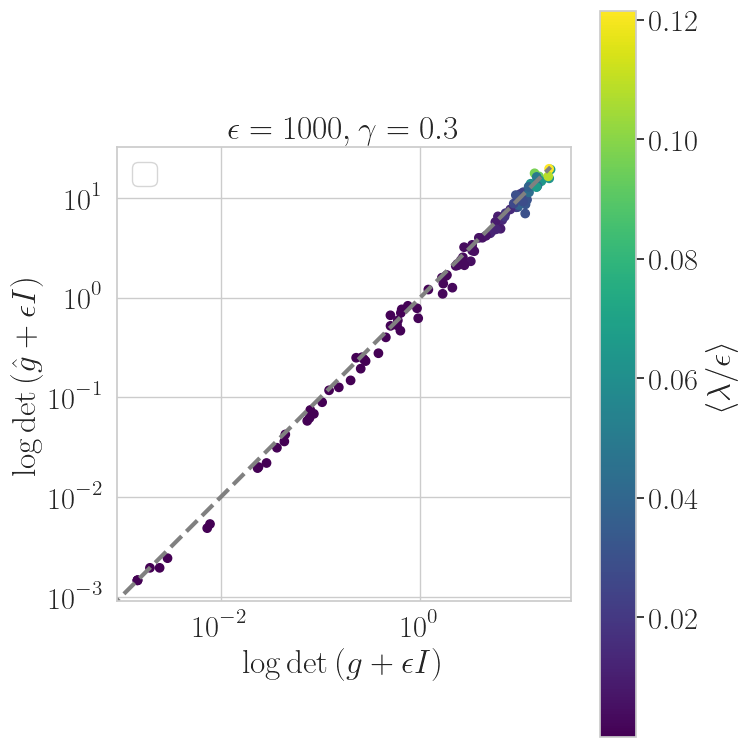

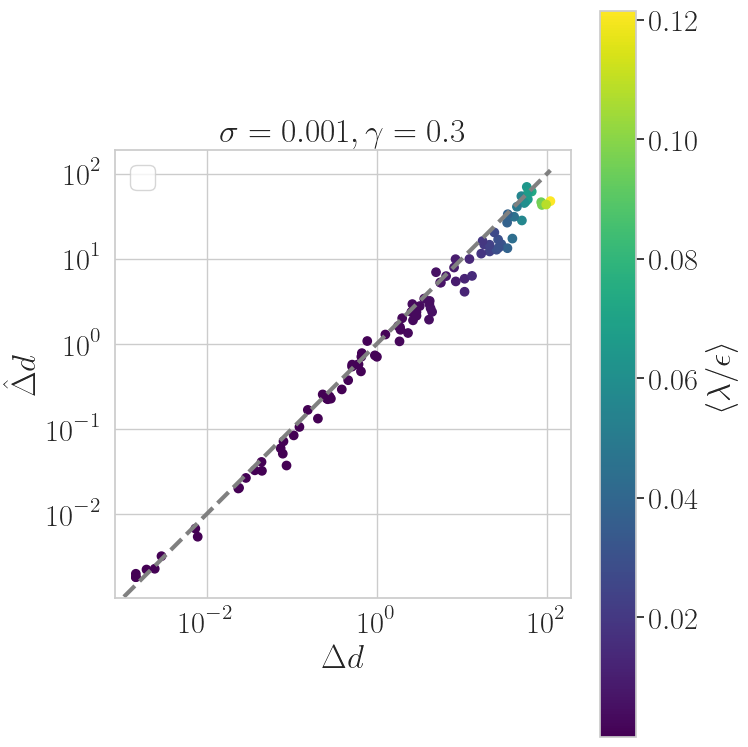

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


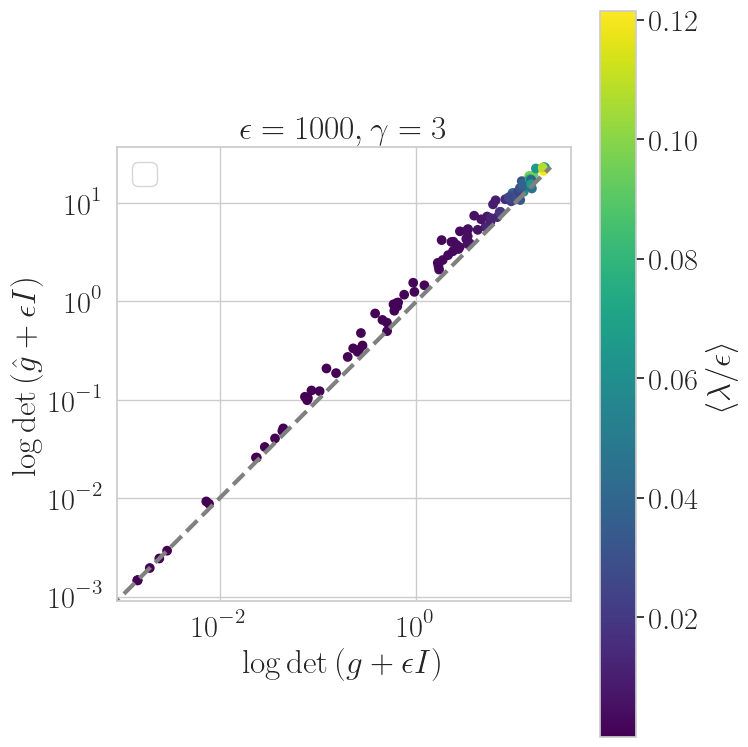

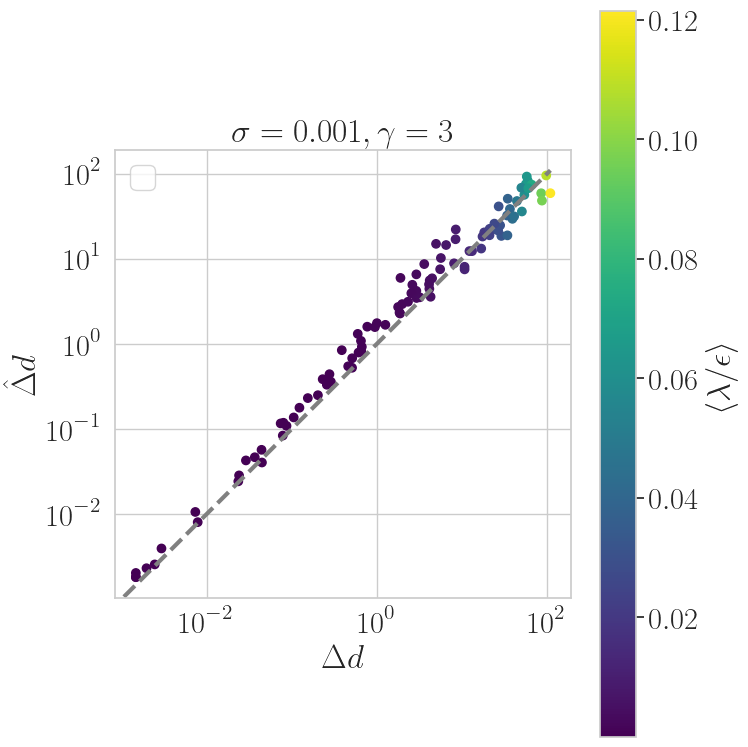

100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


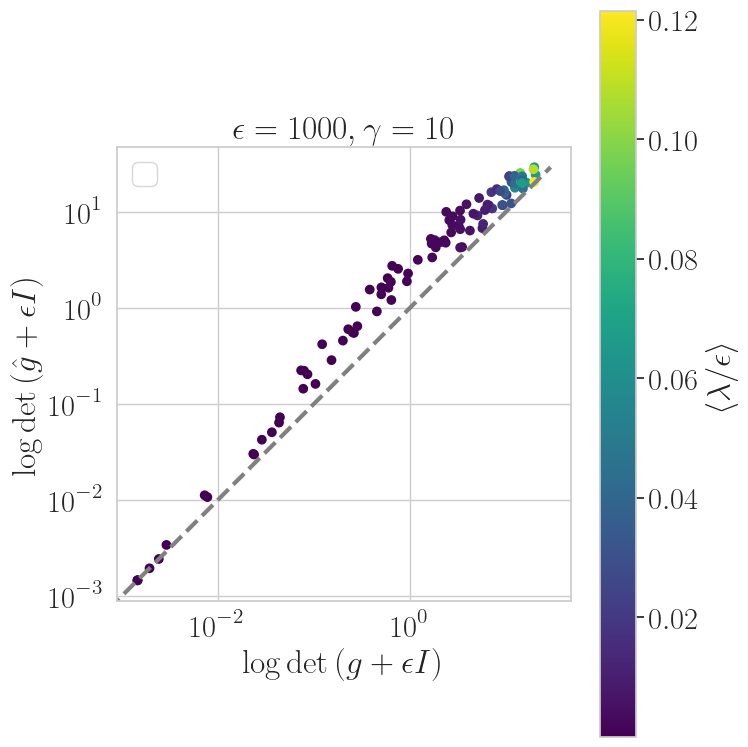

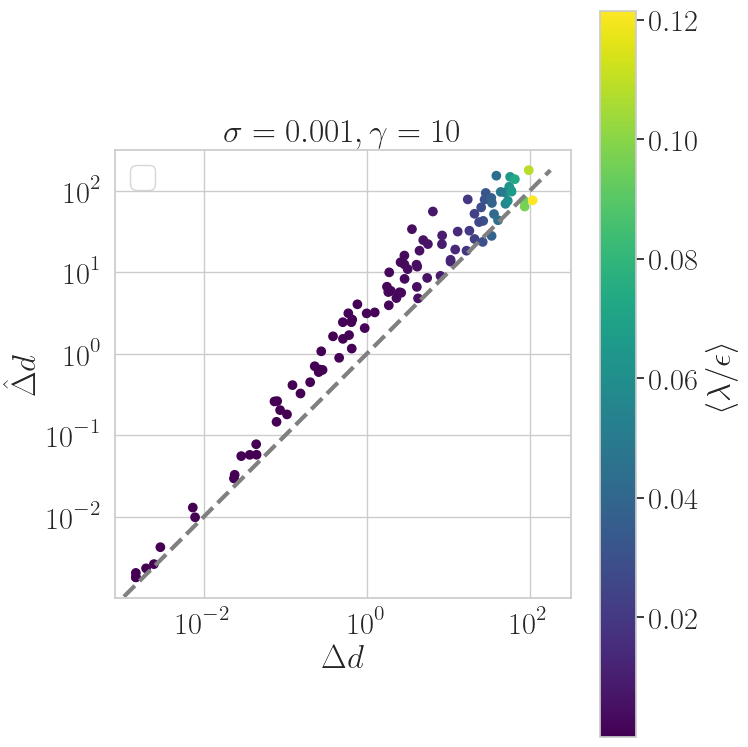

100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


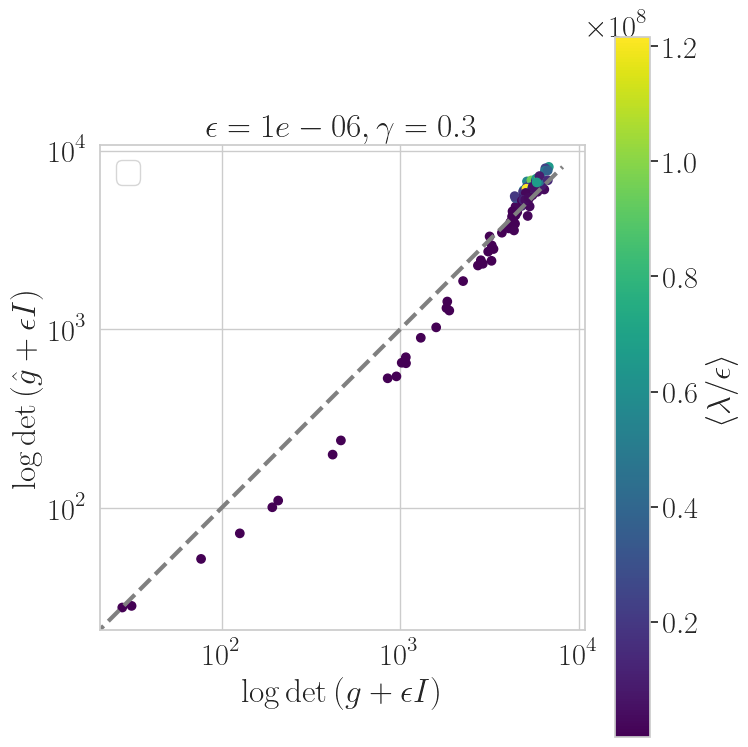

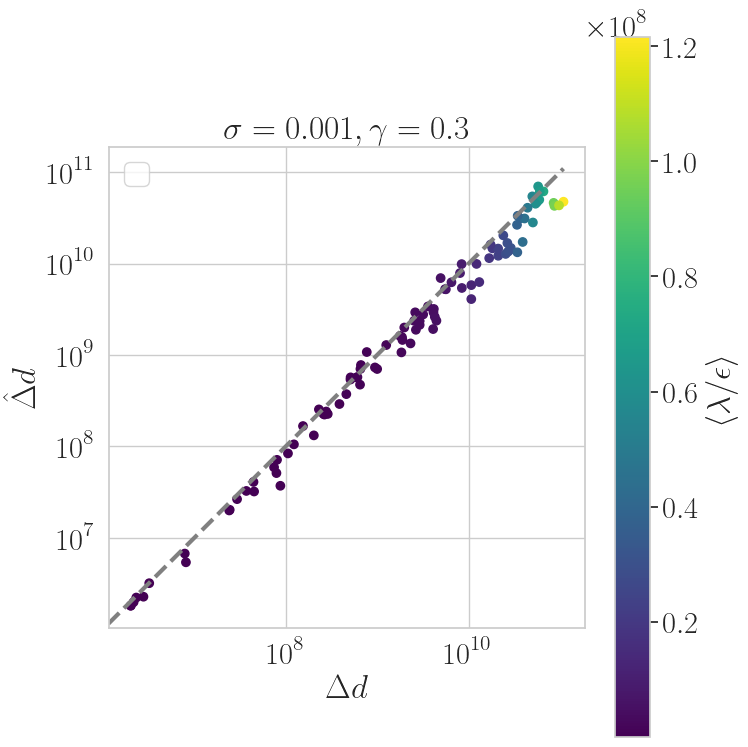

100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


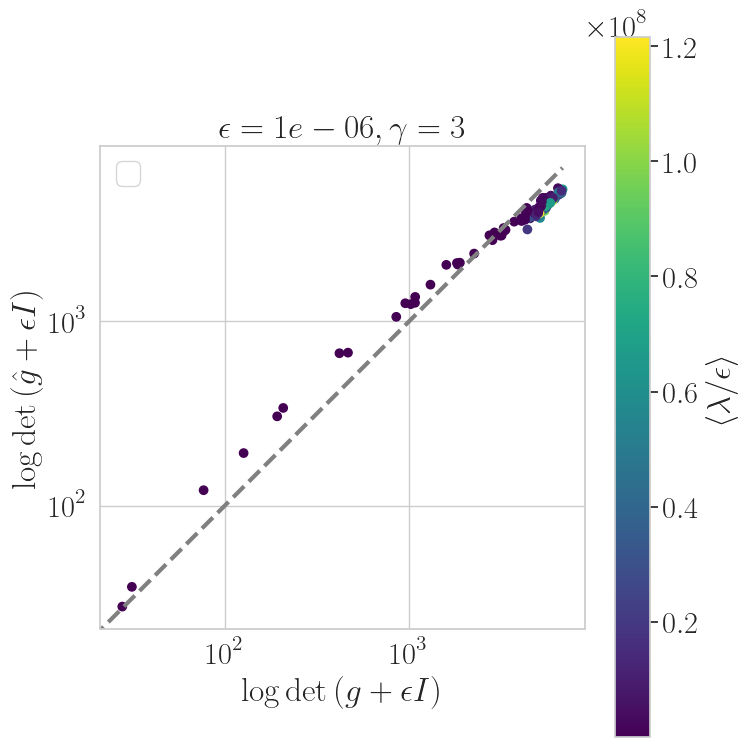

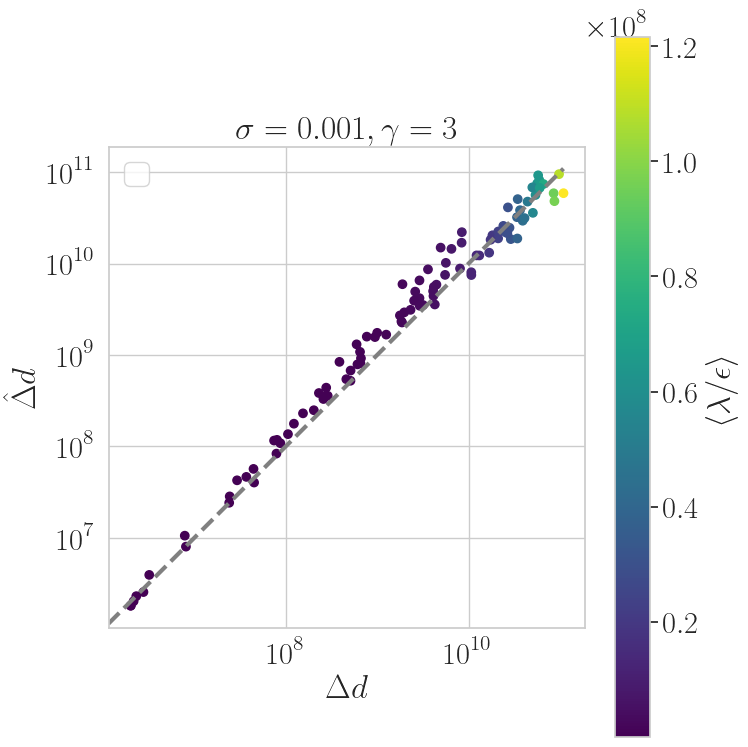

100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


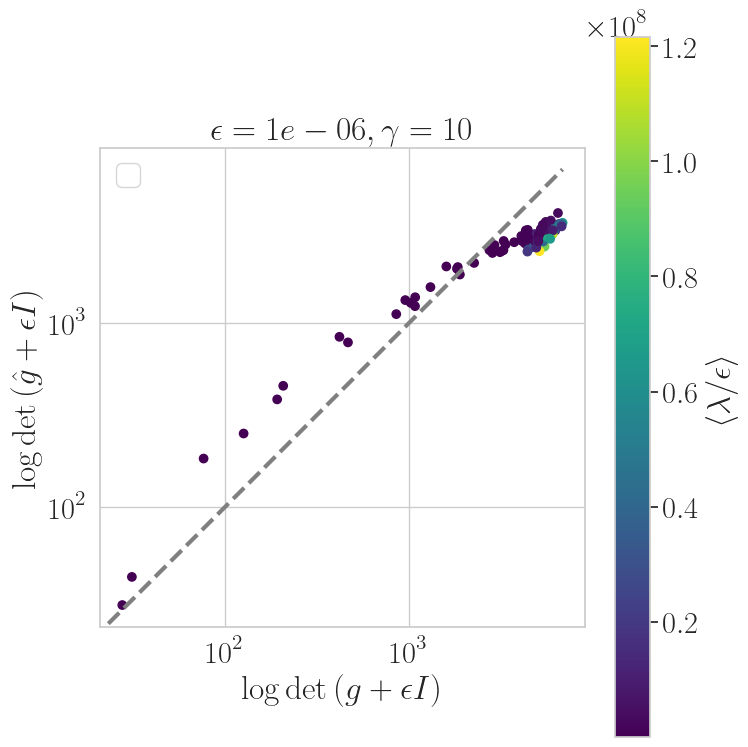

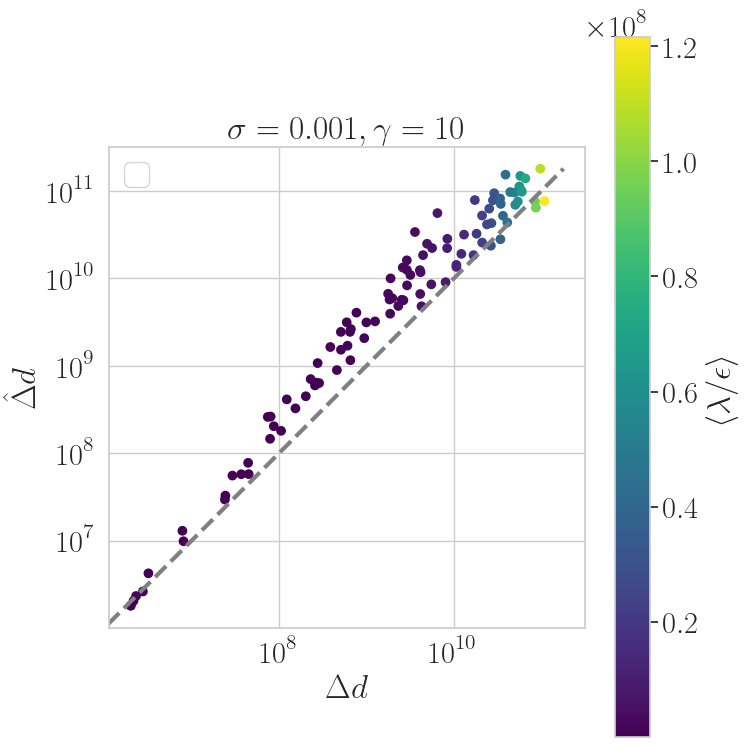

In [26]:
trials = 100
x_context = x_test

# laplacian estimator
n_samples = 10
sigma = 0.01 # noise scale
normalize = False

max_scale = 10

for jitter in [1000, 1e-6]:
    for scale_context in [0.3, 3, 10]:
        for sigma in [0.001]:
            logdets = [] # full eval set
            logdets_n = [] # subsampled eval set
            true_laplacians = [] # true laplacian based on eigenvalues
            laplacian_estimates = [] # estimated laplacian with subsampled eval set
            eig_over_jitter = []
            max_eig_over_jitter = []
            condition = []
            rng_key = jax.random.PRNGKey(0)
            for i in tqdm(range(trials)):
                rng_key, rng_key_sample = jax.random.split(rng_key)
                params = model.init(rng_key_sample, x_train[0][None, :])
                # uniform between 0 and max_scale
                rng_key, rng_key_scale = jax.random.split(rng_key)
                scale = jax.random.uniform(rng_key_scale, shape=(), minval=0, maxval=max_scale)
                params = jax.tree_map(lambda x: x * scale, params)
                logdet_full, eig = log_det_g_svd(model, params, x_context, jitter, return_eig=True, shift_by_jitter=True)
                logdets.append(logdet_full)
                logdet_n = log_det_g_svd(model, params, x_context * scale_context, jitter, return_eig=False, shift_by_jitter=True)
                logdets_n.append(logdet_n)
                eig_over_jitter.append(eig.mean().item() / jitter)
                max_eig_over_jitter.append(eig.max().item() / jitter)
                condition.append(eig.max().item() / (eig.min().item() + 1e-32))
                laplacian_estimates.append(log_det_trace_estimator(model, params, x_context * scale_context, jitter, sigma, n_samples, normalize).item())
                true_laplacians.append(log_det_g_svd_first_order(model, params, x_context, jitter)) # jitter has no effect on this

            laplacian_estimates = np.array(laplacian_estimates)
            logdets = np.array(logdets)
            logdets_n = np.array(logdets_n)
            true_laplacians = np.array(true_laplacians)
            condition = np.array(condition)
            
            plot_compare(logdets, logdets_n, eig_over_jitter, rf'$\log\det\left(g + \epsilon I\right)$', r'$\log\det\left(\hat{g} + \epsilon I\right)$', clabel=r'$\langle \lambda / \epsilon \rangle$', title=rf'$\epsilon = {jitter}, \gamma={scale_context}$', log_axes=True, fit=False)
            plt.savefig(f'objectives/logdet_logdet_n_eps{jitter}_std{sigma}_ctxs{scale_context}_{act}.pdf')
            plt.show()
            plot_compare(true_laplacians, laplacian_estimates, None, r'$\Delta d$', r'$\hat{\Delta} d$', clabel=None, title=rf'$\sigma = {sigma}, \gamma={scale_context}$', log_axes=True, fit=False)
            plt.savefig(f'objectives/truelaplace_laplace_eps{jitter}_std{sigma}_ctxs{scale_context}_{act}.pdf')
            plt.show()

In [ ]:
plot_compare(logdet_svds, logdet_traces, eig_over_jitter, 'log det', 'Laplacian estimate', r'$\langle \lambda / \epsilon \rangle$', rf'$\epsilon = {jitter}$', log_axes=True)

In [ ]:
plot_compare(logdet_svds, logdet_first_order, eig_over_jitter, 'log det', 'log det first order', r'$\langle \lambda / \epsilon \rangle$', rf'$\epsilon = {jitter}$', log_axes=True)

In [ ]:
plot_compare(logdet_first_order, logdet_traces, np.log10(condition), 'log det first order', 'log det trace', r'$\log \kappa$', rf'$\epsilon = {jitter}$',  log_axes=True)